# **Text Generation Model Using GRU for Lyrics Generation**

## **Introduction:**

In this project, we aimed to develop a text generation model using Gated Recurrent Units (GRU) for generating lyrics. The model takes inspiration from a dataset of song lyrics and learns to generate new lyrics based on the patterns and structures observed in the dataset. The process involves several phases including Data Analysis, Pre-processing, Model Building, Model Training, and Generating Lyrics (Prediction).

## **About Dataset**

The Song Lyrics Dataset, sourced from Kaggle, comprises song lyrics from a diverse range of artists. It likely includes information such as the song title, artist name, and the lyrics themselves. This dataset offers a valuable resource for projects involving natural language processing, sentiment analysis, and music-related research. It enables researchers and enthusiasts to analyze patterns, themes, and trends within the lyrics of different songs and artists. Analyzing this dataset can provide insights into the lyrical content of songs across various genres and time periods, offering opportunities for exploring cultural, social, and emotional aspects embedded in music.

The dataset can be accessed from the following URL:
https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset

In [1]:
# for loading & analysing the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for generating the wordcloud (word frequency)
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# for model building 
import tensorflow.keras.utils as utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Activation, Flatten, Dense

# for text generation & evaluation
import sys
from nltk import download
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu

## **Loading the dataset:**

In [2]:
data_directory = "csv"

# Get a list of all CSV files in the directory
data_files = [file for file in os.listdir(data_directory) if file.endswith(".csv")]

data_frames = []
# Read each CSV file and append its DataFrame to the list
for file in data_files:
    file_path = os.path.join(data_directory, file)
    df = pd.read_csv(file_path, encoding='latin1', dtype={"Year": "Int64"})
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
dataset = pd.concat(data_frames,  ignore_index=True)

## **1. Analysing Dataset**

The dataset used for this project consists of a collection of song lyrics from various artists and genres. In this phase, we performed exploratory data analysis to understand the characteristics of the dataset. This involved examining the distribution of lyrics length, vocabulary size, and the frequency of words. Additionally, we identified any preprocessing steps required such as handling special characters, tokenization, and removing stopwords.

In [3]:
dataset.describe()

,Unnamed: 0,Year
count,3592.000000,2507.0
mean,140.173163,2013.45353
std,108.505878,40.592378
min,0.000000,1.0
25%,56.000000,2011.0
50%,117.000000,2016.0
75%,201.000000,2018.0
max,520.000000,2022.0


In [4]:
dataset.isnull().sum()

Unnamed: 0       0
Artist           0
Title            0
Album         1127
Year          1085
Date          1085
Lyric            9
dtype: int64

In [5]:
dataset.dropna(subset=['Lyric'])

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0,Dua Lipa,New Rules,Dua Lipa,2017,2017-06-02,one one one one one talkin' in my sleep at n...
1,1,Dua Lipa,Donât Start Now,Future Nostalgia,2019,2019-11-01,if you don't wanna see me did a full 80 craz...
2,2,Dua Lipa,IDGAF,Dua Lipa,2017,2017-06-02,you call me all friendly tellin' me how much y...
3,3,Dua Lipa,Blow Your Mind (Mwah),Dua Lipa,2016,2016-08-26,i know it's hot i know we've got something tha...
4,4,Dua Lipa,Be the One,Dua Lipa,2015,2015-10-30,i see the moon i see the moon i see the moon o...
...,...,...,...,...,...,...,...
3587,143,Post Malone,Lithium,NaN,2020,2020-04-24,i'm so happy 'cause today i found my friends t...
3588,144,Post Malone,Something in the Way,NaN,2020,2020-04-24,verse underneath the tarp has sprung a leak a...
3589,145,Post Malone,In Bloom,NaN,2020,2020-04-24,sell the kids for food weather changes moods s...
3590,146,Post Malone,Territorial Pissings,NaN,2020,2020-04-24,when i was an alien cultures weren't opinions ...


In [6]:
dataset["Artist"].unique()

array(['Dua Lipa', 'Post Malone', 'Charlie Puth', 'Billie Eilish',
       'Eminem', 'Maroon 5', 'Ed Sheeran', 'Selena Gomez',
       'Justin Bieber', 'Katy Perry'], dtype=object)

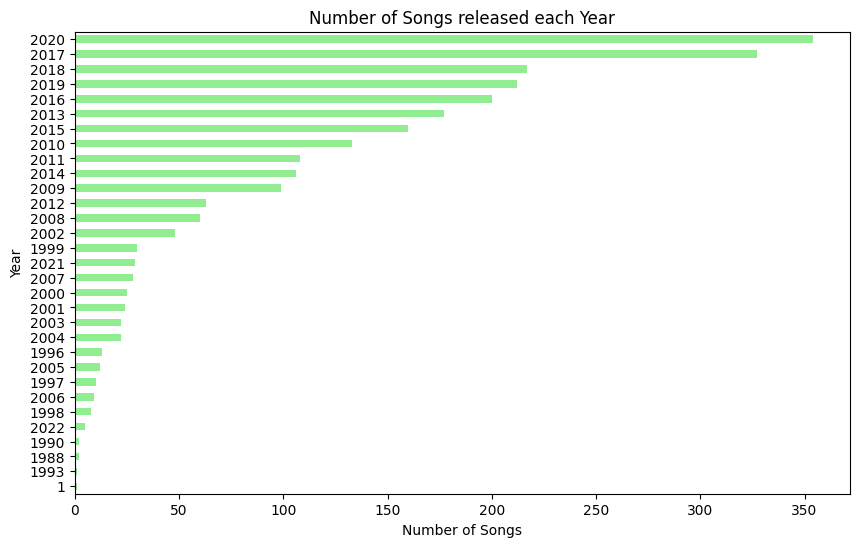

In [7]:
count = dataset['Year'].value_counts()

plt.figure(figsize=(10, 6))
count.plot(kind='barh', color='lightgreen')

plt.title('Number of Songs released each Year')
plt.xlabel('Number of Songs')
plt.ylabel('Year')
plt.gca().invert_yaxis()  # to display the year with most number of songs at the top
plt.show()

### Analysing Number of Songs for each Artist

In [8]:
dataset['Artist'].value_counts()

Artist
Katy Perry       650
Eminem           521
Dua Lipa         494
Selena Gomez     350
Justin Bieber    348
Post Malone      296
Ed Sheeran       296
Billie Eilish    290
Maroon 5         197
Charlie Puth     150
Name: count, dtype: int64


### Top 10 Albums Most Represented

In [9]:
dataset['Album'].value_counts().head(5)

Album
Unreleased Songs          536
Revival                    51
Fingerprints [Shelved]     50
beerbongs & bentleys       36
Stoney (Deluxe)            34
Name: count, dtype: int64


### 10 Most Represented Albums

In [10]:
dataset['Title'].value_counts().head(10)

Title
Stay                                   6
Patient                                5
Trust In Me                            5
Unreleased Songs [Discography List]    5
Stoned                                 4
Scream                                 4
Birthday                               4
Magic                                  4
Rise                                   4
Honest                                 4
Name: count, dtype: int64

### Emotion Representation in Song Lyrics

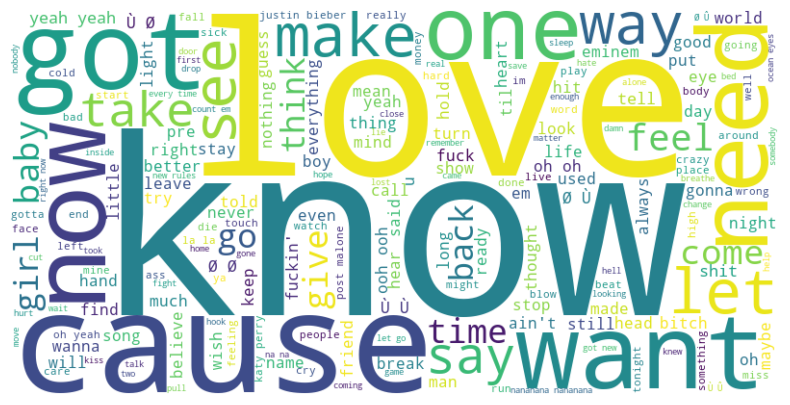

In [11]:
def analyze_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Convert any float values in the 'Lyric' column to strings
dataset['Lyric'] = dataset['Lyric'].astype(str)
# Apply sentiment analysis to each lyric
dataset['sentiment'] = dataset['Lyric'].apply(analyze_sentiment)
# Combine all lyrics into a single string
all_lyrics = ' '.join(dataset['Lyric'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(dataset['Lyric'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_freq.sum(axis=0).sort_values(ascending=False).head(100)

don        11352
like       10756
yeah        8524
know        8521
just        7934
           ...  
cold         768
thought      767
gone         762
people       759
crazy        751
Length: 100, dtype: int64

### **Relation Analysis**
To check if certain artists tend to release albums with a specific theme or style

In [13]:
pd.crosstab(dataset['Artist'], dataset['Album'])

Album,(A) Katy Perry [Shelved],+ (Plus),1.22.03.Acoustic,13 Reasons Why (Season 1),"8 Mile (Battles, Cyphers & Freestyles)",8 Mile: Music from and Inspired by the Motion Picture,92nd Academy Awards Performances,Anger Management 3,Another Cinderella Story - EP,August 26th,...,Work From Home,You Need Me - EP,"You Need Me, I Donât Need You (Remixes)",beerbongs & bentleys,dont smile at me,dont smile at me (Japanese Import),party favor / hotline bling,triple j Like a Version 14,Ã (Multiply),Ã· (Divide)
Artist,,,,,,,,,,,,,,,,,,,,,
Billie Eilish,0,0,0,2,0,0,2,0,0,0,...,0,0,0,0,16,8,2,2,0,0
Charlie Puth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dua Lipa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ed Sheeran,0,16,0,0,0,0,0,0,0,0,...,0,2,4,0,0,0,0,0,21,16
Eminem,0,0,0,0,12,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Justin Bieber,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Katy Perry,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Maroon 5,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Post Malone,0,0,0,0,0,0,0,0,0,20,...,0,0,0,36,0,0,0,0,0,0


## **2. Preprocessing The Lyric**

In this phase, the raw text data is pre-processed to prepare it for model training. Pre-processing steps include tokenization, padding sequences to ensure uniform length, and creating input-output pairs for the model. Furthermore, text data is vectorized to numerical form using techniques such as one-hot encoding or word embeddings to represent words as dense vectors.

In [14]:
lyricsText = ''
for lyrics in dataset['Lyric']:
    lyricsText += lyrics

### 1. Convert the lyrics to lowercase:


In [15]:
raw_text = lyricsText.lower()

### 2. Mapping characters:
+ first to convert chars to ints
+ second to convert ints back to chars


In [16]:
chars = sorted(list(set(raw_text)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))

This process facilitates numerical representation of textual data, reducing memory usage and enabling efficient indexing, encoding, and normalization.

Additionally, the backward mapping allows for the interpretation of results and the generation of text from processed numerical data.

In [17]:
n_char = len(raw_text) # number of all the characters in lyricsText.txt
n_vocab = len(chars) # number of unique characters

In [18]:
print(f"Total Characters: {n_char}") 
print(f"Total Vocab: {n_vocab}")

Total Characters: 6315550
Total Vocab: 119


### 3. Make samples and labels:

In [ ]:
# Process the dataset:
seq_len = 100
data_X = []
data_y = []

for i in range(0, n_char - seq_len, 1):
    # Input Sequence (will be used as samples)
    seq_in  = raw_text[i:i+seq_len]
    # Output sequence (will be used as target)
    seq_out = raw_text[i + seq_len]
    # Store samples in data_X
    data_X.append([chars_int[char] for char in seq_in])
    # Store targets in data_y
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)

print(f"Total Patterns: {n_patterns}")

### 4. Prepare the samples and labels:
to be ready to go into our model.

In [ ]:
# Reshape X to be suitable to go into GRU:
X = np.reshape(data_X , (n_patterns, seq_len, 1))
# Normalizing input data:
X = X / float(n_vocab)
# One hot encode the output targets:
y = utils.to_categorical(data_y)

## **3. Model Building**

The core of the text generation model is built using Gated Recurrent Units (GRU). GRU is a type of recurrent neural network (RNN) that is effective in capturing sequential patterns in data. The model architecture consists of an input layer, an embedding layer, one or more GRU layers, and an output layer. The GRU layers allow the model to retain long-term dependencies and generate coherent sequences of text.

In [ ]:
GRU_layerCount = 3
layer_size = [64, 64, 64] # number of nodes in each layer

In [22]:
model = Sequential()

### Input Layer:

In [ ]:
model.add(GRU(layer_size[0], input_shape = (X.shape[1], X.shape[2]), return_sequences = True))

### Adding Some Hidden Layers: 

In [ ]:
for i in range(1, GRU_layerCount):
    model.add(GRU(layer_size[i], return_sequences=True))

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

### **Building on Existing Model Training**

In [ ]:
model = load_model("GRU-010-1.40250.hdf5")

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 119)            │       761,719 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 119)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,503 (3.15 MB)

 Trainable params: 824,503 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

After we defined the model , we will define the needed callbacks.

### What is a callback ?
A callback is a function that is called after every epoch

in our case we will call the checkpoint callback , what a checkpoint callback does is saving the weights of the model every time the model gets better.

## **4. Training**

A model can't do a thing if it did not train.

As they say **"No train no gain "**

Feel free to tweak `model_params` to get a better model

In [ ]:
# Configure the checkpoint :
checkpoint_name = 'GRU-{epoch:03d}-{loss:.5f}.keras'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(
          X, y,
          epochs = 20,
          batch_size = 128,
          callbacks = callbacks_list,
          verbose = 1,
          validation_split = 0.2,
          validation_data = None,
          shuffle = True,
          initial_epoch = 0,
          steps_per_epoch = None,
          validation_steps = None
         )

### **Loading and Compiling Pre-trained GRU Model**

In [ ]:
import tensorflow
model = tensorflow.keras.layers.TFSMLayer("/Users/amanbarthwal/Library/CloudStorage/GoogleDrive-amanbarthwal0110@gmail.com/My Drive/Programming/Python/AiML/GenAi/Open Ended/lyricsGenerator.ipynb")
model.compile(loss = "categorical_crossentropy", optimizer = "adam")

## **Generating lyrics**

Once the model is trained, it can be used to generate new lyrics based on a given seed text. To generate lyrics, the model takes a seed text as input and predicts the next word or sequence of words based on the learned patterns. This process is repeated iteratively to generate a sequence of words, forming coherent and contextually relevant lyrics. The generated lyrics can be further refined using techniques such as beam search or sampling to improve diversity and creativity.

We first pick a random seed, then we will use it to generate new lyrics character by character.

In [ ]:
# Set a random seed:
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start]
print('Seed:')
seed = ''.join([int_chars[value] for value in pattern])
print(seed)

# number of characters to generate:
generated_characters = 100
# for temperature sampling:
temperature = 0.5
# for top-k sampling:
top_k = 5


generated_lyrics = ""
# Generating Characters:
for i in range(generated_characters):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    
    # Temperature sampling:
    prediction = np.log(prediction) / temperature
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    
    # Top-k sampling:
    sorted_indices = np.argsort(prediction[0])[-top_k:]
    top_k_prediction = prediction[0, sorted_indices]
    top_k_prediction = top_k_prediction / np.sum(top_k_prediction)  # Normalize probabilities
    index = np.random.choice(sorted_indices, p=top_k_prediction)
    
    result = int_chars[index]
    sys.stdout.write(result)
    generated_lyrics += result
    
    # Update pattern for the next character prediction:
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
    
print('\nDone')

Seed:
n't compare me i'm better off just left alone and i ain't even tryin' to go there with record sales 
you see me and do it see i'm still save you wanna sure me i wanna break the flow oh oh oh and when y
Done


## **5. Model Evaluation**

In [ ]:
download('punkt')

[nltk_data] Downloading package punkt to /Users/ab01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Coherence:

Coherence is a crucial metric that evaluates the logical flow and consistency of generated text, assessing how well words and phrases form a cohesive sequence. 

> A coherence score approaching 1 signifies strong coherence, indicating a well-structured and logically progressing narrative. 
> While a lower scores suggest a lack of logical flow, which can impede understanding and readability. 

In tasks like narrative writing or content generation, higher coherence scores are preferred as they enhance clarity and comprehension, facilitating effective communication of ideas.

In [ ]:
def coherence_score(generated_lyrics):
    tokens = word_tokenize(generated_lyrics.lower())
    
    # Compute n-grams
    n = 2 # can adjust the n-gram size as needed
    n_grams = ngrams(tokens, n)
    n_gram_counts = Counter(n_grams) # count occurrences
    
    # Compute coherence score based on unique n-grams
    coherence = len(n_gram_counts) / len(tokens)
    return coherence

### 2. Creativity:

Creativity assesses the novelty and ingenuity of generated text relative to a given corpus or reference, gauging the introduction of fresh ideas. 

The ideal range for creativity varies depending on task demands and context. 
> In creative writing endeavors, elevated creativity scores are coveted, signifying originality and inventiveness. 
> However, in scenarios prioritizing adherence to conventions or styles, a harmonious blend of creativity and adherence may be sought. 

While higher creativity scores are sought after in tasks requiring imaginative output, maintaining balance with coherence and relevance is crucial to ensure the text remains meaningful and suitable for its intended purpose.

In [ ]:
def creativity_score(generated_lyrics, corpus):
    gen_tokens = word_tokenize(generated_lyrics.lower())
    corpus_tokens = word_tokenize(corpus.lower())
    
    unique_words_generated = set(gen_tokens)
    unique_words_corpus = set(corpus_tokens)
    
    # Calculate the percentage of unique words in the generated lyrics compared to the corpus
    creativity = len(unique_words_generated) / len(unique_words_corpus)
    return creativity

### **Metric Score**

In [ ]:
print(f"Coherence score: {coherence_score(generated_lyrics)}")
print(f"Creativity score: {creativity_score(generated_lyrics, corpus=seed)}")

Coherence score: 0.8928571428571429
Creativity score: 0.9047619047619048


## **6. Conclusion**

In conclusion, the text generation model using GRU has shown promising results in generating lyrics based on the patterns learned from the dataset. The model can be further improved by experimenting with different architectures, hyperparameters, and training strategies. Overall, the project demonstrates the potential of deep learning techniques in creative text generation tasks such as lyrics generation.

## **7. References**

1. Text Generation with GRU:
> https://banjodayo39.medium.com/implementation-of-text-generation-with-gated-recurrent-unit-deep-learning-ac11c4347af2

2. Lyrics Generator RNN:
> https://www.kaggle.com/code/karnikakapoor/lyrics-generator-rnn